In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data
import scipy.io as sio
import torch.nn as nn
import numpy as np
import os

from ComplexLayers_Torch import Beam_Classifier, fit
from sklearn.model_selection import train_test_split
from beam_utils import ULA_DFT_codebook as DFT_codebook
from beam_utils import plot_codebook_pattern as plot_codebook


(1) hardware deployment, including number of antennas, beams, power;
(2) hyper-parameters, like batch size and epochs.

In [6]:
np.random.seed(7)
# number of probing beams (N_W)
n_nb = 128
n_wb = 20
# ifTRAMLP = 1
ifDyn = 0
n_antenna = 64
nepoch = 2010        # 200 by default
batch_size = 2000    # 500 by default         
noise_factor = -13 # dB
noise_power_dBm = -161
noiseless = False

tx_power_dBm = 10

Dataloader

In [7]:
h_real_c = []
h_imag_c = []
ifSaveModel = 1

# 'Ordering' dataset here. Concatenation will be done sequentially.'

# dataset = ['O1_28_BS3_800TO1200']
# dataset = ['I3_60_BS1_1TO551', 'I3_60_BS1_552TO1159', 'I3_60_BS2_1TO551', 'I3_60_BS2_552TO1159', 'I2_28B_BS1_1TO701', 'O1_28_BS3_1TO2751']
# dataset = ['O1_28_BS3_1TO2751', 'O1_28B_BS3_800TO1200']
# dataset = ['S1', 'S101']
# dataset = ['I2_28B_BS1_1TO701', 'I2_28B_BS1_1TO701']
dataset = ['O1_28_BS3_800TO1200', 'O1_28B_BS3_800TO1200']
for index, item in enumerate(dataset):
    dataset_name = item
    if ifDyn:
        root = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/'.format(dataset_name)
        if not os.path.isfile(os.path.join(root, '{}_real.npy'.format(dataset_name))):
            fname_h_real = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/h_real.mat'.format(dataset_name)
            fname_h_imag = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/h_imag.mat'.format(dataset_name)
            print("Loading from {}.mat ...".format(dataset_name)) 
            h_real_temp = sio.loadmat(fname_h_real)['h_real'] # in shape of (100, n_row, n_antenna)  
            h_imag_temp = sio.loadmat(fname_h_imag)['h_imag'] # with 100 user grids per row
            h_real_temp = h_real_temp.transpose(1, 0, 2)      # transpose it -> (n_row, 100, n_antenna)
            h_imag_temp = h_imag_temp.transpose(1, 0, 2)      # 
            root = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/'.format(dataset_name)
            print('Writing into {}.npy ...'.format(dataset_name))
            np.save(os.path.join(root, '{}_real.npy'.format(dataset_name)), h_real_temp)
            np.save(os.path.join(root, '{}_imag.npy'.format(dataset_name)), h_imag_temp)
            print('New sub-dataset shape:', h_real_temp.shape)
            
        else:
            print("Loading from {}.npy ...".format(dataset_name)) 
            h_real_temp = np.load(os.path.join(root, '{}_real.npy'.format(dataset_name)))
            h_imag_temp = np.load(os.path.join(root, '{}_imag.npy'.format(dataset_name)))
            print('Sub-dataset shape:', h_real_temp.shape) 
            
        if index == 0:  # if no sub-dataset been concatenated yet
            h_real_c = h_real_temp      # h_real_concatenation
            h_imag_c = h_imag_temp
        else:
            h_real_c = np.concatenate((h_real_c, h_real_temp), axis = 0)
            h_imag_c = np.concatenate((h_imag_c, h_imag_temp), axis = 0)
    else:
        root = './ZY_dataset/{}/'.format(dataset_name)
        if not os.path.isfile(os.path.join(root, '{}_real.npy'.format(dataset_name))):
            fname_h_real = './ZY_dataset/{}/h_real.mat'.format(dataset_name)
            fname_h_imag = './ZY_dataset/{}/h_imag.mat'.format(dataset_name)
            print("Loading from {}.mat ...".format(dataset_name)) 
            h_real_temp = sio.loadmat(fname_h_real)['h_real'] # in shape of (100, n_row, n_antenna)  
            h_imag_temp = sio.loadmat(fname_h_imag)['h_imag'] # with 100 user grids per row
            h_real_temp = h_real_temp.transpose(1, 0, 2)      # transpose it -> (n_row, 100, n_antenna)
            h_imag_temp = h_imag_temp.transpose(1, 0, 2)      # 
            root = './ZY_dataset/{}/'.format(dataset_name)
            print('Writing into {}.npy ...'.format(dataset_name))
            np.save(os.path.join(root, '{}_real.npy'.format(dataset_name)), h_real_temp)
            np.save(os.path.join(root, '{}_imag.npy'.format(dataset_name)), h_imag_temp)
            print('New sub-dataset shape:', h_real_temp.shape)
            
        else:
            print("Loading from {}.npy ...".format(dataset_name)) 
            h_real_temp = np.load(os.path.join(root, '{}_real.npy'.format(dataset_name)))
            h_imag_temp = np.load(os.path.join(root, '{}_imag.npy'.format(dataset_name)))
            print('Sub-dataset shape:', h_real_temp.shape) 
            
        if index == 0:  # if no sub-dataset been concatenated yet
            h_real_c = h_real_temp      # h_real_concatenation
            h_imag_c = h_imag_temp
        else:
            h_real_c = np.concatenate((h_real_c, h_real_temp), axis = 0)
            h_imag_c = np.concatenate((h_imag_c, h_imag_temp), axis = 0)   

print('data shape:', h_real_c.shape) 
h_real = h_real_c
h_imag = h_imag_c


Loading from O1_28_BS3_800TO1200.npy ...
Sub-dataset shape: (144, 100, 64)
Loading from O1_28B_BS3_800TO1200.npy ...
Sub-dataset shape: (144, 100, 64)
data shape: (288, 100, 64)


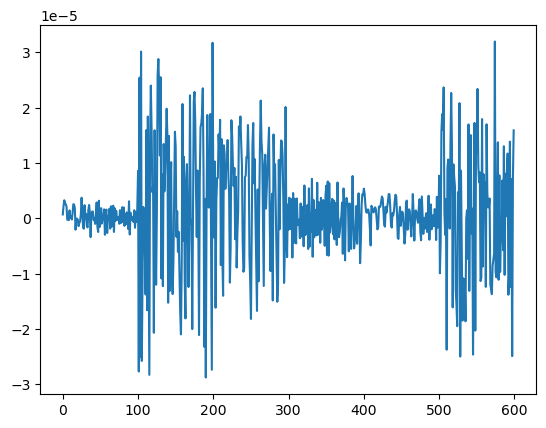

In [8]:
h_real = np.reshape(h_real, (-1, 64))
h_imag = np.reshape(h_imag, (-1, 64))

plt.plot(h_real[300:900, 1])
plt.show()

In [9]:
if noiseless:
    noise_power_dBm = -np.inf    
noise_power = 10**((noise_power_dBm-tx_power_dBm-noise_factor)/10)

h_cplx = h_real + 1j*h_imag
valid_ue_idc = np.array([row_idx for (row_idx, row) in enumerate(np.concatenate((h_real, h_imag), axis=1)) if not all(row == 0)])
h_cplx = h_cplx[valid_ue_idc]
h_real = h_real[valid_ue_idc]
h_imag = h_imag[valid_ue_idc]
norm_factor = np.max(abs(h_cplx))
h_scaled = h_cplx/norm_factor
# np.concatenate: Join a sequence of arrays along an existing axis.
h_concat_scaled = np.concatenate((h_real/norm_factor, h_imag/norm_factor), axis=1)

# Compute EGC gain
egc_gain_scaled = np.power(np.sum(abs(h_scaled), axis = 1), 2)/n_antenna
train_idc, val_idc = train_test_split(np.arange(h_cplx.shape[0]), test_size = 0.117647, shuffle = False)

20 Wide Beams, 128 Narrow Beams.


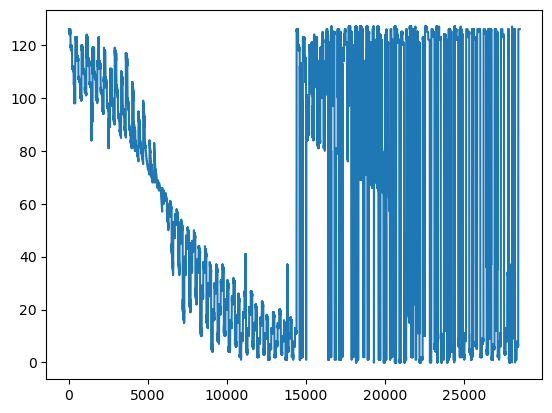

In [10]:
print('{} Wide Beams, {} Narrow Beams.'.format(n_wb, n_nb))

dft_nb_codebook = DFT_codebook(nseg = n_nb, n_antenna = n_antenna)
label = np.argmax(np.power(np.absolute(np.matmul(h_cplx, dft_nb_codebook.conj().T)), 2), axis = 1)
soft_label = np.power(np.absolute(np.matmul(h_cplx, dft_nb_codebook.conj().T)), 2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# dev_cpu = torch.device("cpu")

plt.plot(label[:])
plt.show()

In [11]:
x_train, y_train = h_concat_scaled[train_idc, :], label[train_idc]
x_val, y_val = h_concat_scaled[val_idc, :], label[val_idc]

torch_x_train, torch_y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
torch_x_val, torch_y_val = torch.from_numpy(x_val), torch.from_numpy(y_val)

torch_x_train = torch_x_train.to(device)
torch_y_train = torch_y_train.to(device)
torch_x_val = torch_x_val.to(device)
torch_y_val = torch_y_val.to(device)

train = torch.utils.data.TensorDataset(torch_x_train, torch_y_train)
val = torch.utils.data.TensorDataset(torch_x_val, torch_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

learned_codebooks = []
print('traning set size: {}, test set size: {}.'.format(x_train.shape, x_val.shape))

traning set size: (25168, 128), test set size: (3356, 128).


Trainable probing codebook + MLP classifier, MLP takes the received power as input

In [12]:
# __init__(n_antenna, n_wide_beam, n_narrow_beam, trainable_codebook, theta, complex_codebook, noise_power, norm_factor)
learnableMLP_codebook_model = Beam_Classifier(n_antenna = n_antenna, 
                                              n_wide_beam = n_wb, 
                                              n_narrow_beam = n_nb, 
                                              trainable_codebook = True, 
                                              noise_power = noise_power, 
                                              norm_factor = norm_factor)
learnableMLP_codebook_model = learnableMLP_codebook_model.to(device) 
learnableMLP_codebook_opt = optim.Adam(learnableMLP_codebook_model.parameters(), lr = 0.01, betas = (0.9, 0.999), amsgrad = False)
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = fit(learnableMLP_codebook_model, train_loader, val_loader, learnableMLP_codebook_opt, nn.CrossEntropyLoss(), nepoch)  

Epoch : 0, Training loss = 4.68, Training Acc = 0.03, Validation loss = 3.71, Validation Acc = 0.20.
Epoch : 10, Training loss = 3.85, Training Acc = 0.13, Validation loss = 3.51, Validation Acc = 0.20.


KeyboardInterrupt: 

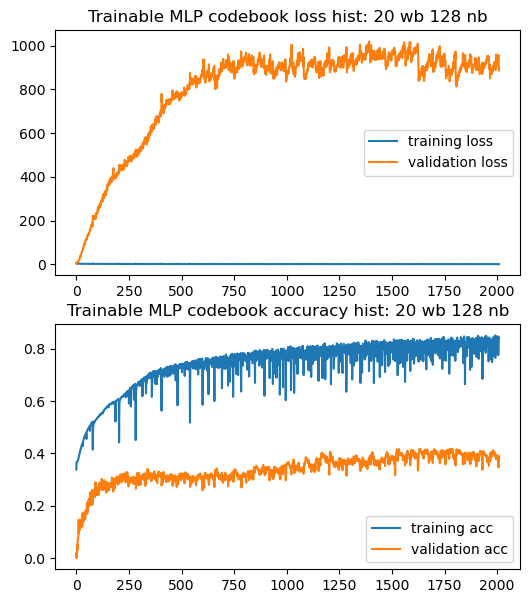

In [9]:
fig1 = plt.figure(num = 1, figsize = (6, 7))

ax1 = fig1.add_subplot(211)
ax1.plot(train_loss_hist, label = 'training loss')
ax1.plot(val_loss_hist, label = 'validation loss')
plt.legend()
plt.title('Trainable MLP codebook loss hist: {} wb {} nb'.format(n_wb, n_nb))

ax1 = fig1.add_subplot(212)
ax1.plot(train_acc_hist, label = 'training acc')
ax1.plot(val_acc_hist, label = 'validation acc')
plt.legend()
plt.title('Trainable MLP codebook accuracy hist: {} wb {} nb'.format(n_wb, n_nb))

plt.show()

In [10]:
if ifSaveModel:
    model_savefname = './ZY_dataset/SaveModel/J_{}_{}wb.pt'.format(dataset[0], n_wb)
    torch.save(learnableMLP_codebook_model.state_dict(), model_savefname)

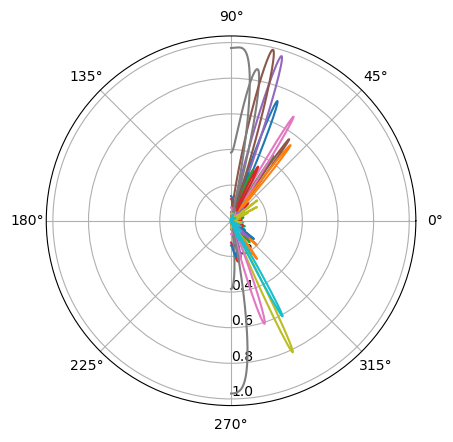

In [11]:
temp_codebook = learnableMLP_codebook_model.get_codebook()
temp_codebook = np.array(temp_codebook).transpose(1, 0)
# fig, ax = plot_codebook(temp_codebook.transpose(1, 0))
fig, ax = plot_codebook(temp_codebook)